# SAFT-VR-Mie

The SAFT-VR-Mie EOS of Lafitte et al. (https://doi.org/10.1063/1.4819786) is based on the use of a Mie potential of the form

$$
u(r) = C\epsilon \left((\sigma/r)^{\lambda_r}-(\sigma/r)^{\lambda_a}\right)
$$
with 
$$
C = \frac{\lambda_r}{\lambda_r-\lambda_a}\left(\frac{\lambda_r}{\lambda_a}\right)^{\lambda_a/(\lambda_r-\lambda_a)}
$$

which allows for a better representation of thermodynamic properties in general, but not always.

In [1]:
import teqp
teqp.__version__

'0.18.0'

In [2]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import scipy.integrate

In [3]:
# Show two ways to instantiate a SAFT-VR-Mie model, the
# first by providing the coefficients, and the second
# by providing the name of the species. Only a very small
# number of molecules are provided for testing, you should
# plan on providing your own parameters.
# 
# Show that both give the same result for the residual pressure

z = np.array([1.0])
model = teqp.make_model({
    "kind": 'SAFT-VR-Mie',
    "model": {
        "coeffs": [{
            "name": "Ethane",
            "BibTeXKey": "Lafitte",
            "m": 1.4373,
            "epsilon_over_k": 206.12, # [K]
            "sigma_m": 3.7257e-10,
            "lambda_r": 12.4,
            "lambda_a": 6.0
        }]
    }
})
display(model.get_Ar01(300, 300, z))

model = teqp.make_model({
    "kind": 'SAFT-VR-Mie',
    "model": {
        "names": ["Ethane"]
    }
})
display(model.get_Ar01(300, 300, z))

-0.04926724350863724

-0.04926724350863724

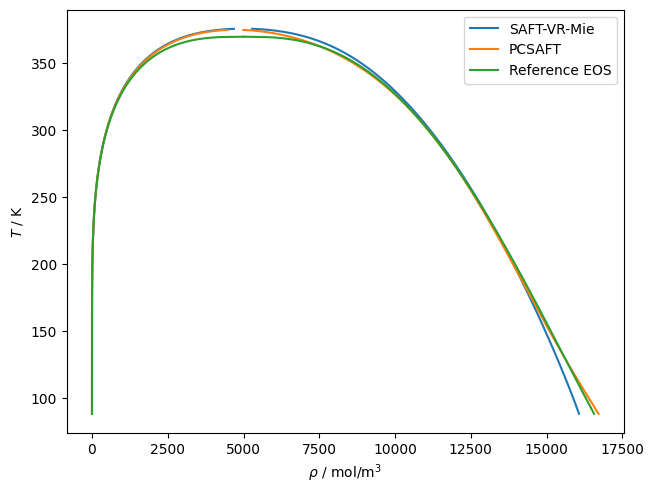

In [4]:
# Here is an example of using teqp to trace VLE for propane
# with the default parameters of PC-SAFT and SAFT-VR-Mie
# models
for kind in ['SAFT-VR-Mie', 'PCSAFT']:
    j = {
        "kind": kind,
        "model": {
            "names": ["Propane"]
        }
    }
    model = teqp.make_model(j)

    z = np.array([1.0])
    Tc, rhoc = model.solve_pure_critical(300, 10000)

    # Extrapolate away from the critical point
    Ti = Tc*0.9997
    rhoL, rhoV = model.extrapolate_from_critical(Tc, rhoc, Ti)

    o = []
    T = Ti
    while T > 88:
        rhoL, rhoV = model.pure_VLE_T(T, rhoL, rhoV, 10)
        T -= 0.1
        o.append({'rhoL': rhoL, 'rhoV': rhoV, 'T': T})

    df = pandas.DataFrame(o)
    line, = plt.plot(df['rhoL'], df['T'], label=kind)
    plt.plot(df['rhoV'], df['T'], color=line.get_color())

# From the reference EOS of Lemmon et al. via CoolProp
name = 'Propane'
Tc = CP.PropsSI(name, 'Tcrit')
Ts = np.linspace(88, Tc, 1000)
rhoL = CP.PropsSI('Dmolar','T',Ts,'Q',0,name)
rhoV = CP.PropsSI('Dmolar','T',Ts,'Q',1,name)
line, = plt.plot(rhoL, Ts, label='Reference EOS')
plt.plot(rhoV, Ts, line.get_color())

plt.gca().set(xlabel=r'$\rho$ / mol/m$^3$', ylabel=r'$T$ / K')
plt.legend()
plt.tight_layout(pad=0.2)
plt.savefig('SAFTVRMIE_PCSAFT.pdf')
plt.show()

In [5]:
# Time calculation of critical points
for kind in ['SAFT-VR-Mie', 'PCSAFT']:
    j = {
        "kind": kind,
        "model": {
            "names": ["Propane"]
        }
    }
    model = teqp.make_model(j)

    z = np.array([1.0])
    %timeit model.solve_pure_critical(300, 10000)

1.36 ms ± 1.19 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


233 µs ± 585 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


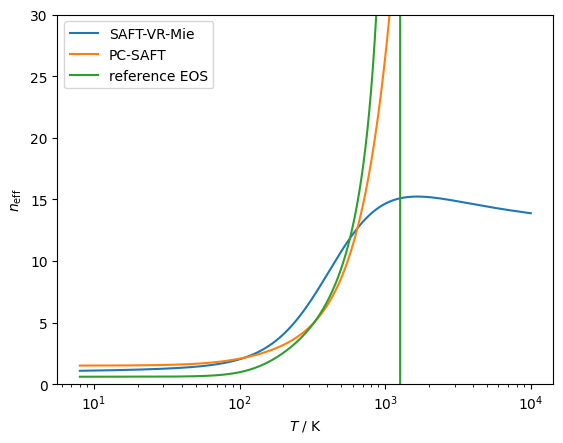

In [6]:
# Checking the effective hardness of interaction,
# the neff parameter defined in https://doi.org/10.1063/5.0007583
# SAFT-VR-Mie comes closest to the right behavior
modelVR = teqp.make_model({
        "kind": 'SAFT-VR-Mie',
        "model": { "names": ["Methane"] }
})
modelPCSAFT = teqp.make_model({
        "kind": 'PCSAFT',
        "model": { "names": ["Methane"] }
})
modelMF = teqp.build_multifluid_model(["Methane"], teqp.get_datapath())

for model, label in [(modelVR, 'SAFT-VR-Mie'), 
                     (modelPCSAFT, 'PC-SAFT'), 
                     (modelMF, 'reference EOS')]:
    z = np.array([1.0])
    rho = 1e-5
    T = np.geomspace(8, 10000, 10000)
    neff = []
    for T_ in T:
        neff.append(model.get_neff(T_, rho, z))
    plt.plot(T, neff, label=label)
plt.xscale('log')
plt.ylim(0, 30)
plt.gca().set(xlabel=r'$T$ / K', ylabel=r'$n_{\rm eff}$')
plt.legend()
plt.show()

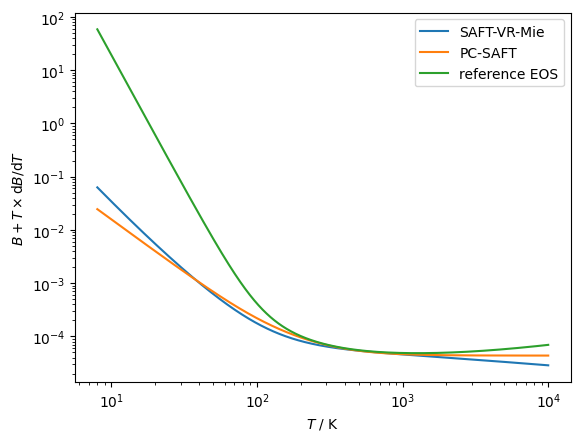

In [7]:
# Checking the temperature derivative of the virial coefficient
name = 'Methane'
modelVR = teqp.make_model({
        "kind": 'SAFT-VR-Mie',
        "model": { "names": [name] }
})
modelPCSAFT = teqp.make_model({
        "kind": 'PCSAFT',
        "model": { "names": [name] }
})
modelMF = teqp.build_multifluid_model([name], teqp.get_datapath())

for model, label in [(modelVR, 'SAFT-VR-Mie'), 
                     (modelPCSAFT, 'PC-SAFT'), 
                     (modelMF, 'reference EOS')]:
    z = np.array([1.0])
    T = np.geomspace(8, 10000, 10000)
    n = 2
    B, TdBdT, thetan = [],[],[]
    for T_ in T:
        TdBdT.append(model.get_dmBnvirdTm(n, 1, T_, z)*T_)
        B.append(model.get_dmBnvirdTm(n, 0, T_, z))
        thetan.append(B[-1]+TdBdT[-1])
    plt.plot(T, thetan, label=label)
plt.xscale('log')
plt.yscale('log')
plt.gca().set(xlabel=r'$T$ / K', ylabel=r'$B+T\times$d$B$/d$T$')
plt.legend()
plt.show()

In [8]:
# Time model instantiation
for kind in ['SAFT-VR-Mie', 'PCSAFT']:
    j = {
        "kind": kind,
        "model": {
            "names": ["Propane"]
        }
    }
    %timeit teqp.make_model(j)

1 ms ± 4.15 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


416 µs ± 1.69 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Calculation of diameter

The calculation of the diameter is based upon
$$
d_{ii} = \int_0^{\sigma_{ii}}(1-\exp(-\beta u_{ii}^{\rm Mie}(r)){\rm d}r
$$
but the integrand is basically constant from 0 to some cutoff value of $r$, which we'll call $r_{\rm cut}$. So first we need to find the value of $r_{\rm cut}$ that makes the integrand take its constant value, which is explained well in the paper from Aasen (https://github.com/ClapeyronThermo/Clapeyron.jl/issues/152#issuecomment-1480324192).  Finding the cutoff value is obtained when 
$$
\exp(-\beta u_{ii}^{\rm Mie}(r)) = EPS
$$
where EPS is the numerical precision of the floating point type. Taking the logs of both sides, 
$$
-\beta u_{ii}^{\rm Mie} = \ln(EPS)
$$

To get a starting value, it is first assumed that only the repulsive contribution contributes to the potential, yielding $u^{\rm rep} = C\epsilon(\sigma/r)^{\lambda_r}$ which yields
$$
-\beta C\epsilon(\sigma/r)^{\lambda_r} = \ln(EPS)
$$
and 
$$
(\sigma/r)_{\rm guess} = (-\ln(EPS)/(\beta C \epsilon))^{1/\lambda_r}
$$

Then we solve for the residual $R(r)=0$, where $R_0=\exp(-u/T)-EPS$.  Equivalently we can write the residual in logarithmic terms as $R=-u/T-\ln(EPS)$. This simplifies the rootfinding as you need $R$, $R'$ and $R''$ to apply Halley's method, which are themselves quite straightforward to obtain because $R'=-u'/T$, $R''=-u''/T$, where the primes are derivatives taken with respect to $\sigma/r$.

In [9]:
# Calculation of the residual function (needed for Halley's method)
import sympy as sy
kappa, j, lambda_r, lambda_a = sy.symbols('kappa, j, lambda_r, lambda_a')
u = kappa*(j**lambda_r - j**lambda_a)
display(sy.diff(u, j))
display(sy.simplify(sy.diff(u, j, 2)))

kappa*(-j**lambda_a*lambda_a/j + j**lambda_r*lambda_r/j)

kappa*(-j**lambda_a*lambda_a**2 + j**lambda_a*lambda_a + j**lambda_r*lambda_r**2 - j**lambda_r*lambda_r)/j**2

In [10]:
# Here is a small example of using adaptive quadrature 
# to obtain the quasi-exact value of d for ethane
# according to the pure-fluid parameters given in 
# Lafitte et al.

epskB = 206.12 # [K]
sigma_m = 3.7257e-10 # [m]
lambda_r = 12.4 
lambda_a = 6.0
C = lambda_r/(lambda_r-lambda_a)*(lambda_r/lambda_a)**(lambda_a/(lambda_r-lambda_a))
T = 300.0 # [K]

# The classical method based on adaptive quadrature
def integrand(r_m):
    u = C*epskB*((sigma_m/r_m)**(lambda_r) - (sigma_m/r_m)**(lambda_a))
    return 1.0 - np.exp(-u/T)

print('quasi-exact; (value, error estimate):')
exact, exact_error = scipy.integrate.quad(integrand, 0.0, sigma_m, epsrel=1e-16, epsabs=1e-16)
print(exact*1e10, exact_error*1e10)

j = {"kind": 'SAFT-VR-Mie', "model": {"names": ["Ethane"]}}
model = teqp.make_model(j)
d = model.get_core_calcs(T, -1, z)["dmat"][0][0]
print('teqp; (value, error from quasi-exact in %)')
print(d, abs(d/(exact*1e10)-1)*100)

quasi-exact; (value, error estimate):
3.597838592720949 3.228005612223332e-12
teqp; (value, error from quasi-exact in %)
3.597838640613809 1.331156429529301e-06
